In [1]:
"""
PLOT IMPACT OF SAGITTARIUS ON OUTER DISC
"""
import numpy as np
import os
import pandas as pd
import coord_trans as ct
import scipy.optimize as sciOpt
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [2]:
PLOTFOLDER          = "../plots/impactofsag/"
TEST                = True
NTEST               = 10000
ZMIN                = 0.6 #kpc
ZMAX                = 1.  #kpc

## Read observations, mock data, and stellar positions and velocities after impact

In [3]:
# Read in obseved velocity dispersion profiles for young/old stars in outer disk
young_ages_df = pd.read_csv("../data/sigz_young_ages_beyondplane.csv")
old_ages_df   = pd.read_csv("../data/sigz_old_ages_beyondplane.csv")

# Read saved mock galaxy data
wc = np.loadtxt("../results/impactofsag/mock_mw_wc.txt")
wp = ct.CartesianToPolar(wc)
index = (np.abs(wp[:,2]) > ZMIN ) & (np.abs(wp[:,2] < ZMAX))
wp_beyond_plane = wp[index,:]
wc_beyond_plane = wc[index,:]
print(len(wp_beyond_plane))

12430


## Calculate vertical velocity dispersion profiles above and below plane

In [4]:
# Define objective function to maximize for estimation of robust velocity dispersion
# sigma - velocity dispersion
# vel   - vector of velocities
# eVel  - vector of velocity uncertainties
# mu    - mean velocity
def sigmaObjFunc(sigma,vel,eVel,mu):
    
    y = ((vel-mu)**2.)/((sigma**2.+eVel**2.)**2.) - (1./(sigma**2.+eVel**2.))
    
    return (np.sum(y))

# Number of sigma for clipping
f = 5.

In [5]:
# Define variables
R_min        = 6.
R_max        = 14.
n_R          = 10
R_edges      = np.logspace(np.log10(R_min),np.log10(R_max),n_R+1)

R_bin        = np.zeros(n_R)
sigz_bin     = np.zeros(n_R)
sigz_err_bin = np.zeros(n_R)

# Plot for different masses

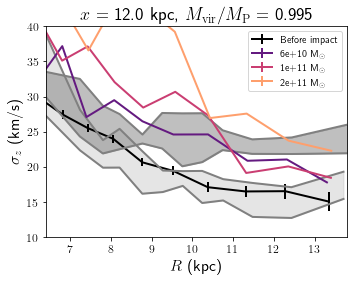

In [12]:
RUNNOS              = [79,74,54]
IMPACT_MASSES       = [6e10,1e11,2e11]
IMPACT_PARAMETER    = 12.
VIRIAL_MASS_RATIO   = 0.995
n_runs = len(RUNNOS)

fig,ax = plt.subplots(1,1,figsize=(5,4))
for j_R in range(n_R):
        
        ## OBSERVATIONS
        # Define R region
        R_index = ((R_edges[j_R]<wp_beyond_plane[:,0]) & (wp_beyond_plane[:,0]<R_edges[j_R+1])) 
               
        # Calculate mean vz
        mean = np.mean(wp_beyond_plane[R_index,5])
                
        # Calculate initial guess for sigz
        sigma = np.std(wp_beyond_plane[R_index,5])
        
        # Clip velocities beyond three sigma
        clipped_index = (wp_beyond_plane[:,5] > (mean-f*sigma)) & (wp_beyond_plane[:,5] < (mean+f*sigma))
        index   = clipped_index * R_index
        
        # Calculate mean radii of clipped velocities
        R_bin[j_R] = np.mean(wp_beyond_plane[index,0])
        
        n = np.sum(index)
        
        # Recalculate mean
        mean = np.mean(wp_beyond_plane[index,5])
        
        # Maximise likelihood to find robust measure of observed velocity dispersion
        intervalMin = 0.
        intervalMax = 100.
        opt_sigz = sciOpt.brentq(sigmaObjFunc,intervalMin,intervalMax, 
                                 args=(wp_beyond_plane[index,5],wp_beyond_plane[index,5]*0.+0.5,mean), 
                                 xtol=2e-12, rtol=8.881784197001252e-16, 
                                 maxiter=100, full_output=False)
        sigz_bin[j_R] = opt_sigz
        n = np.sum(index)
        sigz_err_bin[j_R] = opt_sigz * np.sqrt(1./(2.*n))
        
ax.errorbar(R_bin,sigz_bin,yerr=sigz_err_bin,linestyle="-",linewidth=2, color="black",label="Before impact")
ax.errorbar(young_ages_df["R"],young_ages_df["min_sigz"],linestyle="-",linewidth=2,color="gray")
ax.errorbar(young_ages_df["R"],young_ages_df["max_sigz"],linestyle="-",linewidth=2,color="gray")
ax.fill_between(young_ages_df["R"],young_ages_df["min_sigz"],young_ages_df["max_sigz"],color="gray",alpha=0.2)
ax.errorbar(old_ages_df["R"],old_ages_df["min_sigz"],linestyle="-",linewidth=2,color="gray")
ax.errorbar(old_ages_df["R"],old_ages_df["max_sigz"],linestyle="-",linewidth=2,color="gray")
ax.fill_between(old_ages_df["R"],old_ages_df["min_sigz"],old_ages_df["max_sigz"],color="gray",alpha=0.5)
ax.tick_params(axis="x",labelsize=12)
ax.tick_params(axis="y",labelsize=12)
ax.set_title("$x$ = "+str(IMPACT_PARAMETER)+" kpc, $M_{\mathrm{vir}}/M_{\mathrm{P}}$ = 0.995",fontsize=18)
ax.set_xlabel(r"$R$ (kpc)",fontsize=16)
ax.set_ylabel(r"$\sigma_z$ (km/s)",fontsize=16) 
ax.set_xlim([6.4,13.8])
ax.set_ylim([10.,40.0])

import matplotlib.pylab as pl
colors = pl.cm.magma(np.linspace(0.3,0.8,n_runs))

for j_run in range(n_runs):

    RUNFOLDER           = "../results/impactofsag/run"+str(RUNNOS[j_run])
    if (TEST):
        VKICKSOUTPUTFILE    = RUNFOLDER+"/vKicks_test"+str(NTEST)+".csv"
        EVOLVEDDFOUTPUTFILE = RUNFOLDER+"/evolvedDF_test"+str(NTEST)+".csv"
    else:
        VKICKSOUTPUTFILE    = RUNFOLDER+"/vKicks.csv"
        EVOLVEDDFOUTPUTFILE = RUNFOLDER+"/evolvedDF.csv"
        
    # Read evolved DF file
    wc_evolved_DF = pd.read_csv(EVOLVEDDFOUTPUTFILE)
    wc_evolved    = wc_evolved_DF.values[:,1:]
    wp_evolved    = ct.CartesianToPolar(wc_evolved)
    index         = (np.abs(wp_evolved[:,2]) > ZMIN) & (np.abs(wp_evolved[:,2]) < ZMAX)
    wp_evolved_beyond_plane = wp_evolved[index,:]
    
    R_evolved_bin        = np.zeros(n_R)
    sigz_evolved_bin     = np.zeros(n_R)
    sigz_err_evolved_bin = np.zeros(n_R)

    for j_R in range(n_R):
        
        ### MODEL
        # Define R region
        R_index = ((R_edges[j_R]<wp_evolved_beyond_plane[:,0]) & (wp_evolved_beyond_plane[:,0]<R_edges[j_R+1])) 
               
        # Calculate mean vz
        mean = np.mean(wp_evolved_beyond_plane[R_index,5])
                
        # Calculate initial guess for sigz
        sigma = np.std(wp_evolved_beyond_plane[R_index,5])
        
        # Clip velocities beyond three sigma
        clipped_index = (wp_evolved_beyond_plane[:,5] > (mean-f*sigma)) & (wp_evolved_beyond_plane[:,5] < (mean+f*sigma))
        index   = clipped_index * R_index
        
        n = np.sum(index)
    
        if (n==0):
            R_evolved_bin[j_R]        = np.nan
            sigz_evolved_bin[j_R]     = np.nan
            sigz_err_evolved_bin[j_R] = np.nan
        else:
        
            # Calculate mean radii of clipped velocities
            R_evolved_bin[j_R] = np.mean(wp_evolved_beyond_plane[index,0])
        
            # Recalculate mean
            mean = np.mean(wp_evolved_beyond_plane[index,5])
        
            # Maximise likelihood to find robust measure of observed velocity dispersion
            opt_sigz = sciOpt.brentq(sigmaObjFunc,intervalMin,intervalMax, 
                                     args=(wp_evolved_beyond_plane[index,5],wp_evolved_beyond_plane[index,5]*0.+0.5,mean), 
                                     xtol=2e-12, rtol=8.881784197001252e-16, 
                                     maxiter=100, full_output=False)
            sigz_evolved_bin[j_R] = opt_sigz

            sigz_err_evolved_bin[j_R] = opt_sigz * np.sqrt(1./(2.*n))
          

    ax.errorbar(R_evolved_bin,sigz_evolved_bin,yerr=0.*sigz_err_evolved_bin,linestyle="-",linewidth=2,
                label=str('%.e' % IMPACT_MASSES[j_run])+r" M$_{\odot}$",color=colors[j_run])
ax.legend()
plt.tight_layout(pad=1)
plt.savefig(PLOTFOLDER+"/sag_impact_collection_different_masses.pdf",format="pdf")

# Plots for different concentrations

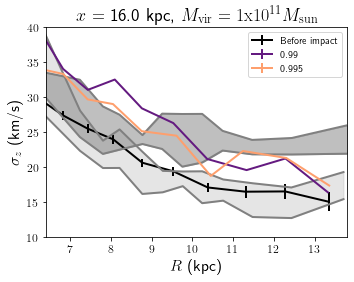

In [13]:
RUNNOS              = [68,73]
IMPACT_MASSES       = 1e11
IMPACT_PARAMETER    = 16.
VIRIAL_MASS_RATIO   = [0.99,0.995]
n_runs = len(RUNNOS)

fig,ax = plt.subplots(1,1,figsize=(5,4))
for j_R in range(n_R):
        
        ## OBSERVATIONS
        # Define R region
        R_index = ((R_edges[j_R]<wp_beyond_plane[:,0]) & (wp_beyond_plane[:,0]<R_edges[j_R+1])) 
               
        # Calculate mean vz
        mean = np.mean(wp_beyond_plane[R_index,5])
                
        # Calculate initial guess for sigz
        sigma = np.std(wp_beyond_plane[R_index,5])
        
        # Clip velocities beyond three sigma
        clipped_index = (wp_beyond_plane[:,5] > (mean-f*sigma)) & (wp_beyond_plane[:,5] < (mean+f*sigma))
        index   = clipped_index * R_index
        
        # Calculate mean radii of clipped velocities
        R_bin[j_R] = np.mean(wp_beyond_plane[index,0])
        
        n = np.sum(index)
        
        # Recalculate mean
        mean = np.mean(wp_beyond_plane[index,5])
        
        # Maximise likelihood to find robust measure of observed velocity dispersion
        intervalMin = 0.
        intervalMax = 100.
        opt_sigz = sciOpt.brentq(sigmaObjFunc,intervalMin,intervalMax, 
                                 args=(wp_beyond_plane[index,5],wp_beyond_plane[index,5]*0.+0.5,mean), 
                                 xtol=2e-12, rtol=8.881784197001252e-16, 
                                 maxiter=100, full_output=False)
        sigz_bin[j_R] = opt_sigz
        n = np.sum(index)
        sigz_err_bin[j_R] = opt_sigz * np.sqrt(1./(2.*n))
        
ax.errorbar(R_bin,sigz_bin,yerr=sigz_err_bin,linestyle="-",linewidth=2, color="black",label="Before impact")
ax.errorbar(young_ages_df["R"],young_ages_df["min_sigz"],linestyle="-",linewidth=2,color="gray")
ax.errorbar(young_ages_df["R"],young_ages_df["max_sigz"],linestyle="-",linewidth=2,color="gray")
ax.fill_between(young_ages_df["R"],young_ages_df["min_sigz"],young_ages_df["max_sigz"],color="gray",alpha=0.2)
ax.errorbar(old_ages_df["R"],old_ages_df["min_sigz"],linestyle="-",linewidth=2,color="gray")
ax.errorbar(old_ages_df["R"],old_ages_df["max_sigz"],linestyle="-",linewidth=2,color="gray")
ax.fill_between(old_ages_df["R"],old_ages_df["min_sigz"],old_ages_df["max_sigz"],color="gray",alpha=0.5)
ax.tick_params(axis="x",labelsize=12)
ax.tick_params(axis="y",labelsize=12)
ax.set_title("$x$ = "+str(IMPACT_PARAMETER)+" kpc, $M_{\mathrm{vir}} = 1 \mathrm{x} 10^{11} M_{\mathrm{sun}}$",fontsize=18)
ax.set_xlabel(r"$R$ (kpc)",fontsize=16)
ax.set_ylabel(r"$\sigma_z$ (km/s)",fontsize=16) 
ax.set_xlim([6.4,13.8])
ax.set_ylim([10.,40.0])

import matplotlib.pylab as pl
colors = pl.cm.magma(np.linspace(0.3,0.8,n_runs))

for j_run in range(n_runs):

    RUNFOLDER           = "../results/impactofsag/run"+str(RUNNOS[j_run])
    if (TEST):
        VKICKSOUTPUTFILE    = RUNFOLDER+"/vKicks_test"+str(NTEST)+".csv"
        EVOLVEDDFOUTPUTFILE = RUNFOLDER+"/evolvedDF_test"+str(NTEST)+".csv"
    else:
        VKICKSOUTPUTFILE    = RUNFOLDER+"/vKicks.csv"
        EVOLVEDDFOUTPUTFILE = RUNFOLDER+"/evolvedDF.csv"
        
    # Read evolved DF file
    wc_evolved_DF = pd.read_csv(EVOLVEDDFOUTPUTFILE)
    wc_evolved    = wc_evolved_DF.values[:,1:]
    wp_evolved    = ct.CartesianToPolar(wc_evolved)
    index         = (np.abs(wp_evolved[:,2]) > ZMIN) & (np.abs(wp_evolved[:,2]) < ZMAX)
    wp_evolved_beyond_plane = wp_evolved[index,:]
    
    R_evolved_bin        = np.zeros(n_R)
    sigz_evolved_bin     = np.zeros(n_R)
    sigz_err_evolved_bin = np.zeros(n_R)

    for j_R in range(n_R):
        
        ### MODEL
        # Define R region
        R_index = ((R_edges[j_R]<wp_evolved_beyond_plane[:,0]) & (wp_evolved_beyond_plane[:,0]<R_edges[j_R+1])) 
               
        # Calculate mean vz
        mean = np.mean(wp_evolved_beyond_plane[R_index,5])
                
        # Calculate initial guess for sigz
        sigma = np.std(wp_evolved_beyond_plane[R_index,5])
        
        # Clip velocities beyond three sigma
        clipped_index = (wp_evolved_beyond_plane[:,5] > (mean-f*sigma)) & (wp_evolved_beyond_plane[:,5] < (mean+f*sigma))
        index   = clipped_index * R_index
        
        n = np.sum(index)
    
        if (n==0):
            R_evolved_bin[j_R]        = np.nan
            sigz_evolved_bin[j_R]     = np.nan
            sigz_err_evolved_bin[j_R] = np.nan
        else:
        
            # Calculate mean radii of clipped velocities
            R_evolved_bin[j_R] = np.mean(wp_evolved_beyond_plane[index,0])
        
            # Recalculate mean
            mean = np.mean(wp_evolved_beyond_plane[index,5])
        
            # Maximise likelihood to find robust measure of observed velocity dispersion
            opt_sigz = sciOpt.brentq(sigmaObjFunc,intervalMin,intervalMax, 
                                     args=(wp_evolved_beyond_plane[index,5],wp_evolved_beyond_plane[index,5]*0.+0.5,mean), 
                                     xtol=2e-12, rtol=8.881784197001252e-16, 
                                     maxiter=100, full_output=False)
            sigz_evolved_bin[j_R] = opt_sigz

            sigz_err_evolved_bin[j_R] = opt_sigz * np.sqrt(1./(2.*n))
          

    ax.errorbar(R_evolved_bin,sigz_evolved_bin,yerr=0.*sigz_err_evolved_bin,linestyle="-",linewidth=2,
                label=str(VIRIAL_MASS_RATIO[j_run]),color=colors[j_run])
ax.legend()
plt.tight_layout(pad=1)
plt.savefig(PLOTFOLDER+"/sag_impact_collection_different_concentrations.pdf",format="pdf")

# Plots at different impact parameters

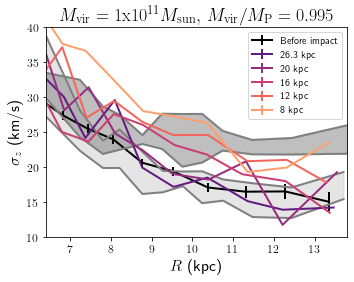

In [14]:
RUNNOS              = [76,77,78,79,80]
IMPACT_MASSES       = 6e10
IMPACT_PARAMETER    = [26.3,20,16,12,8]
VIRIAL_MASS_RATIO   = 0.995
n_runs = len(RUNNOS)

fig,ax = plt.subplots(1,1,figsize=(5,4))
for j_R in range(n_R):
        
        ## OBSERVATIONS
        # Define R region
        R_index = ((R_edges[j_R]<wp_beyond_plane[:,0]) & (wp_beyond_plane[:,0]<R_edges[j_R+1])) 
               
        # Calculate mean vz
        mean = np.mean(wp_beyond_plane[R_index,5])
                
        # Calculate initial guess for sigz
        sigma = np.std(wp_beyond_plane[R_index,5])
        
        # Clip velocities beyond three sigma
        clipped_index = (wp_beyond_plane[:,5] > (mean-f*sigma)) & (wp_beyond_plane[:,5] < (mean+f*sigma))
        index   = clipped_index * R_index
        
        # Calculate mean radii of clipped velocities
        R_bin[j_R] = np.mean(wp_beyond_plane[index,0])
        
        n = np.sum(index)
        
        # Recalculate mean
        mean = np.mean(wp_beyond_plane[index,5])
        
        # Maximise likelihood to find robust measure of observed velocity dispersion
        intervalMin = 0.
        intervalMax = 100.
        opt_sigz = sciOpt.brentq(sigmaObjFunc,intervalMin,intervalMax, 
                                 args=(wp_beyond_plane[index,5],wp_beyond_plane[index,5]*0.+0.5,mean), 
                                 xtol=2e-12, rtol=8.881784197001252e-16, 
                                 maxiter=100, full_output=False)
        sigz_bin[j_R] = opt_sigz
        n = np.sum(index)
        sigz_err_bin[j_R] = opt_sigz * np.sqrt(1./(2.*n))
        
ax.errorbar(R_bin,sigz_bin,yerr=sigz_err_bin,linestyle="-",linewidth=2, color="black",label="Before impact")
ax.errorbar(young_ages_df["R"],young_ages_df["min_sigz"],linestyle="-",linewidth=2,color="gray")
ax.errorbar(young_ages_df["R"],young_ages_df["max_sigz"],linestyle="-",linewidth=2,color="gray")
ax.fill_between(young_ages_df["R"],young_ages_df["min_sigz"],young_ages_df["max_sigz"],color="gray",alpha=0.2)
ax.errorbar(old_ages_df["R"],old_ages_df["min_sigz"],linestyle="-",linewidth=2,color="gray")
ax.errorbar(old_ages_df["R"],old_ages_df["max_sigz"],linestyle="-",linewidth=2,color="gray")
ax.fill_between(old_ages_df["R"],old_ages_df["min_sigz"],old_ages_df["max_sigz"],color="gray",alpha=0.5)
ax.tick_params(axis="x",labelsize=12)
ax.tick_params(axis="y",labelsize=12)
ax.set_title("$M_{\mathrm{vir}} = 1 \mathrm{x} 10^{11} M_{\mathrm{sun}},\, M_{\mathrm{vir}}/M_{\mathrm{P}} = 0.995$",fontsize=18)
ax.set_xlabel(r"$R$ (kpc)",fontsize=16)
ax.set_ylabel(r"$\sigma_z$ (km/s)",fontsize=16) 
ax.set_xlim([6.4,13.8])
ax.set_ylim([10.,40.0])

import matplotlib.pylab as pl
colors = pl.cm.magma(np.linspace(0.3,0.8,n_runs))

for j_run in range(n_runs):

    RUNFOLDER           = "../results/impactofsag/run"+str(RUNNOS[j_run])
    if (TEST):
        VKICKSOUTPUTFILE    = RUNFOLDER+"/vKicks_test"+str(NTEST)+".csv"
        EVOLVEDDFOUTPUTFILE = RUNFOLDER+"/evolvedDF_test"+str(NTEST)+".csv"
    else:
        VKICKSOUTPUTFILE    = RUNFOLDER+"/vKicks.csv"
        EVOLVEDDFOUTPUTFILE = RUNFOLDER+"/evolvedDF.csv"
        
    # Read evolved DF file
    wc_evolved_DF = pd.read_csv(EVOLVEDDFOUTPUTFILE)
    wc_evolved    = wc_evolved_DF.values[:,1:]
    wp_evolved    = ct.CartesianToPolar(wc_evolved)
    index         = (np.abs(wp_evolved[:,2]) > ZMIN) & (np.abs(wp_evolved[:,2]) < ZMAX)
    wp_evolved_beyond_plane = wp_evolved[index,:]
    
    R_evolved_bin        = np.zeros(n_R)
    sigz_evolved_bin     = np.zeros(n_R)
    sigz_err_evolved_bin = np.zeros(n_R)

    for j_R in range(n_R):
        
        ### MODEL
        # Define R region
        R_index = ((R_edges[j_R]<wp_evolved_beyond_plane[:,0]) & (wp_evolved_beyond_plane[:,0]<R_edges[j_R+1])) 
               
        # Calculate mean vz
        mean = np.mean(wp_evolved_beyond_plane[R_index,5])
                
        # Calculate initial guess for sigz
        sigma = np.std(wp_evolved_beyond_plane[R_index,5])
        
        # Clip velocities beyond three sigma
        clipped_index = (wp_evolved_beyond_plane[:,5] > (mean-f*sigma)) & (wp_evolved_beyond_plane[:,5] < (mean+f*sigma))
        index   = clipped_index * R_index
        
        n = np.sum(index)
    
        if (n==0):
            R_evolved_bin[j_R]        = np.nan
            sigz_evolved_bin[j_R]     = np.nan
            sigz_err_evolved_bin[j_R] = np.nan
        else:
        
            # Calculate mean radii of clipped velocities
            R_evolved_bin[j_R] = np.mean(wp_evolved_beyond_plane[index,0])
        
            # Recalculate mean
            mean = np.mean(wp_evolved_beyond_plane[index,5])
        
            # Maximise likelihood to find robust measure of observed velocity dispersion
            opt_sigz = sciOpt.brentq(sigmaObjFunc,intervalMin,intervalMax, 
                                     args=(wp_evolved_beyond_plane[index,5],wp_evolved_beyond_plane[index,5]*0.+0.5,mean), 
                                     xtol=2e-12, rtol=8.881784197001252e-16, 
                                     maxiter=100, full_output=False)
            sigz_evolved_bin[j_R] = opt_sigz

            sigz_err_evolved_bin[j_R] = opt_sigz * np.sqrt(1./(2.*n))
          

    ax.errorbar(R_evolved_bin,sigz_evolved_bin,yerr=0.*sigz_err_evolved_bin,linestyle="-",linewidth=2,
                label=str(IMPACT_PARAMETER[j_run])+" kpc",color=colors[j_run])
ax.legend()
plt.tight_layout(pad=1)
plt.savefig(PLOTFOLDER+"/sag_impact_collection_different_impact_parameters.pdf",format="pdf")